# Analyse 3D du centre galactique

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion, make_mean_psf, make_mean_edisp
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.cube import MapMaker, PSFKernel, MapDataset
from gammapy.modeling.models import (
    SkyModel,
    SkyDiffuseCube,
    BackgroundModel,
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.spectrum import FluxPointsEstimator
from gammapy.modeling import Fit

On va prendre toutes les observations depuis 2003 dont la direction d'observation se trouve dans un rayon de 5 degrés autour du centre galactique.

In [3]:
# Define which data to use and print some information
data_store = DataStore.from_dir("../data/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: ../data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 122853
OBS_ID: 18092 -- 151486
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 20485



In [4]:
from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(2, 'deg'),
                 border=Angle(0, 'deg'))
selected_obs_table = data_store.obs_table.select_observations(selection)

In [5]:
len(selected_obs_table)

954

In [150]:
obs_ids = list(selected_obs_table["OBS_ID"])[:200]
observations = data_store.get_observations(obs_ids)

In [151]:
for obs in observations:
    try:
        obs.aeff
        obs.edisp
        obs.psf
    except:
        obs_ids.remove(obs.obs_id)
        print("Observation retirée : " + str(obs.obs_id))

observations = data_store.get_observations(obs_ids)

Found multiple HDU matching: OBS_ID = 20191, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss


Observation retirée : 20191


Found multiple HDU matching: OBS_ID = 20193, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20194, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss


Observation retirée : 20193
Observation retirée : 20194


In [152]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1.0, 2.0, 5), unit="TeV", name="energy", interp="log")

geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(14, 10),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

In [153]:
%%time
maker = MapMaker(geom, offset_max=4.0 * u.deg)
maps = maker.run(observations)

CPU times: user 12min 1s, sys: 3min 33s, total: 15min 34s
Wall time: 16min 9s


In [154]:
path = Path("analysis_3d_gc_bis")
path.mkdir(exist_ok=True)

# write maps
maps["counts"].write(str(path / "countsGC200.fits"), overwrite=True)
maps["background"].write(str(path / "backgroundGC200.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposureGC200.fits"), overwrite=True)

In [155]:
# read maps
path = Path("analysis_3d_gc_bis")
maps = {
    "counts": Map.read(str(path / "countsGC200.fits")),
    "background": Map.read(str(path / "backgroundGC200.fits")),
    "exposure": Map.read(str(path / "exposureGC200.fits")),
}

In [156]:
print(maps)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (700, 500, 4)
	ndim  : 3
	unit  : 
	dtype : >f4
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (700, 500, 4)
	ndim  : 3
	unit  : 
	dtype : >f8
, 'exposure': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (700, 500, 4)
	ndim  : 3
	unit  : m2 s
	dtype : >f4
}


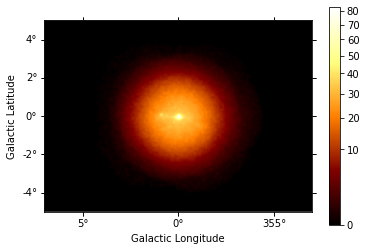

In [225]:
counts = maps["counts"].sum_over_axes()
counts.smooth(width=0.05 * u.deg).plot(stretch="sqrt", add_cbar=True);

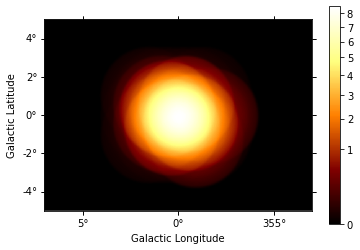

In [226]:
background = maps["background"].sum_over_axes()
background.smooth(width=0.05 * u.deg).plot(
    stretch="sqrt", add_cbar=True
);

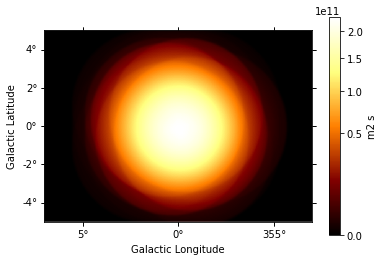

In [227]:
exposure = maps["exposure"].sum_over_axes()
exposure.smooth(width=0.05 * u.deg).plot(stretch="sqrt", add_cbar=True);

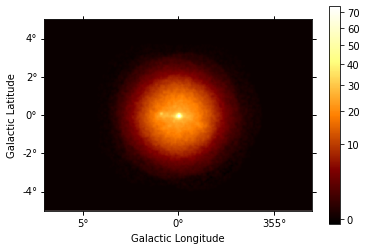

In [228]:
excess = counts - background
excess.smooth(width=0.05 * u.deg).plot(stretch="sqrt", add_cbar=True);

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x121004b38>)

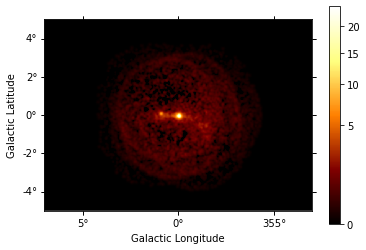

In [163]:
excess_2D = maps["counts"] - maps["background"]

excess_slice = excess_2D.slice_by_idx({"energy":1})
excess_slice.smooth(width=0.05 * u.deg).plot(stretch="sqrt", vmin=0, add_cbar=True
)

# Prise en compte éventuelle de l'émission diffuse

# Prise en compte des IRF

In [164]:
# mean PSF
src_pos = SkyCoord(0.1, 0.1, unit="deg", frame="galactic")
table_psf = make_mean_psf(observations, src_pos)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.4 deg")

In [165]:
# define energy grid
energy = energy_axis.edges

# mean edisp
edisp = make_mean_edisp(
    observations, position=src_pos, e_true=energy, e_reco=energy
)

In [166]:
# write IRFs
psf_kernel.write(str(path / "psfGC200.fits"), overwrite=True)
edisp.write(str(path / "edispGC200.fits"), overwrite=True)

In [45]:
# read IRFs
psf_kernel = PSFKernel.read(str(path / "psfGC200.fits"))
edisp = EnergyDispersion.read(str(path / "edispGC200.fits"))

# Fit du modèle

In [214]:
coords = maps["counts"].geom.get_coord()
mask = coords["energy"] > 0.1 * u.TeV

In [215]:
spatial_model = PointSpatialModel(
    lon_0="0.01 deg", lat_0="0.01 deg", frame="galactic"
)

spectral_model = PowerLawSpectralModel(index=2.2, amplitude="3e-12 cm-2 s-1 TeV-1", reference="1 TeV")

#spectral_model = ExpCutoffPowerLawSpectralModel(index=1.956, amplitude=1.523e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV, lambda_ = 0.1135 / u.TeV )

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name='SgrA*')

In [216]:
background_model = BackgroundModel(maps["background"], norm=1.1, tilt=0.0)
background_model.parameters["norm"].frozen = False
background_model.parameters["tilt"].frozen = True

In [ ]:
#Ring background
geom_image = maps["counts"].geom.to_image()

#regions = CircleSkyRegion(center=spatial_model.position, radius=0.3 * u.deg)

regions = RectangleSkyRegion(center=spatial_model.position, width=2 * u.deg, height=0.5 * u.deg, angle=0 * u.deg)

exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)

ring_bkg = RingBackgroundEstimator(r_in="0.3 deg", width="0.3 deg")

In [217]:
dataset = MapDataset(
    model=model,
    counts=maps["counts"],
    exposure=maps["exposure"],
    background_model=background_model,
    psf=psf_kernel,
    edisp=edisp,
)

In [218]:
%%time
fit = Fit(dataset)
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 2.522E+06               |     Ncalls=183 (188 total)     |
| EDM = 2.74E+04 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
CPU times: user 5.28 s, sys: 1.8 s, total: 7.08 s
Wall time: 7.09 s


In [219]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,9.674e-03,1.707e-11,deg,nan,nan,False
lat_0,1.000e-02,1.717e-11,deg,-9.000e+01,9.000e+01,False
index,2.200e+00,3.741e-09,,nan,nan,False
amplitude,3.000e-12,6.455e-21,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.432e+00,1.159e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


On vérifie le fit du modèle en faisant une carte des résidus.

In [220]:
npred = dataset.npred()

In [221]:
residual = maps["counts"] - npred

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1216a9828>)

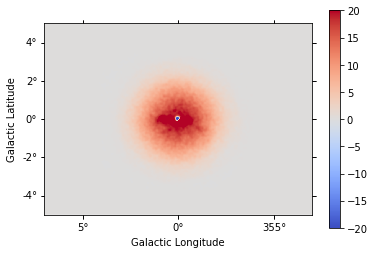

In [222]:
residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-20, vmax=20, add_cbar=True
)
#plt.savefig("residusGC200_1.pdf");

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x12447b7b8>)

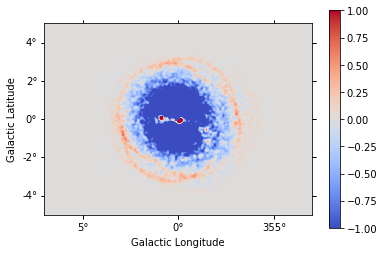

In [208]:
m_sub = residual.slice_by_idx({"energy": 1})
m_sub.smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-1, vmax=1, add_cbar=True
)

## Prise en compte de SgrA* et de G0.9+0.1

On essaie un autre modèle : *plusieurs sources ponctuelles qui émettent en loi de puissance.*

In [60]:

spatial_model2 = PointSpatialModel(lon_0="0.9 deg", lat_0="0.1 deg", frame="galactic")

#spatial_model3 = PointSpatialModel(lon_0="358 deg", lat_0="2 deg", frame="galactic")
#spatial_model4 = PointSpatialModel(lon_0="6 deg", lat_0="0.01 deg", frame="galactic")

spectral_model = PowerLawSpectralModel(index=2.2, amplitude="3e-12 cm-2 s-1 TeV-1", reference="1 TeV")

model2 = SkyModel(spatial_model=spatial_model2, spectral_model=spectral_model, name='src1')

#model3 = SkyModel(spatial_model=spatial_model3, spectral_model=spectral_model, name='src2')
#model4 = SkyModel(spatial_model=spatial_model4, spectral_model=spectral_model, name='src3')

In [61]:
dataset.model = model + model2 # + model3 + model4

In [62]:
%%time
fit2 = Fit(dataset)
result2 = fit.run(optimize_opts={"print_level": 1})

#fit3 = Fit(dataset3)
#result3 = fit.run(optimize_opts={"print_level": 1})

#fit4 = Fit(dataset4)
#result4 = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 8.974E+05               |      Ncalls=93 (98 total)      |
| EDM = 2.53E+04 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
CPU times: user 9.41 s, sys: 3.83 s, total: 13.2 s
Wall time: 13.6 s


In [63]:
result2.parameters.to_table()


name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,9.663e-03,2.381e-10,deg,nan,nan,False
lat_0,9.998e-03,2.691e-10,deg,-9.000e+01,9.000e+01,False
index,2.200e+00,5.643e-08,,nan,nan,False
amplitude,3.000e-12,6.411e-20,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.804e+00,2.248e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [64]:
npred2 = dataset.npred()

In [65]:
residual2 = maps["counts"] - npred2

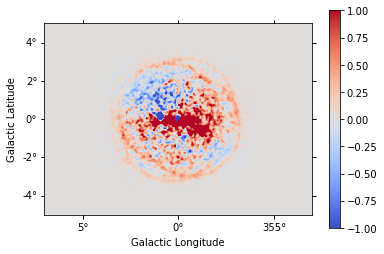

In [74]:
residual2.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-1, vmax=1, add_cbar=True
);